# Import libraries

In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. load data

In [2]:
# Adding a path to the directory with etl.py
sys.path.append(os.path.abspath('..\src\preprocessing'))

from etl_process import ETL  # Impotr ETL

path_to_data = r'..\data'  # Specify the path to your data

etl = ETL(path_to_data) 
etl.extract()
etl.transform()
train_df, test_df = etl.load()


# 2. EDA


## 2.1 Time series analysis

In [3]:
_train_df = train_df.copy()

_train_df['date__week_of_start_sales'] = (_train_df['date']-min(_train_df['date'])).dt.days//7
_train_df.rename(columns = {'date_block_num' : 'date__month_of_start_sales'}, inplace = True)

_train_df['date__day_of_month'] = _train_df['date'].dt.day
_train_df['date__day_of_week'] = _train_df['date'].dt.dayofweek
_train_df['date__week_of_year'] = _train_df['date'].dt.isocalendar().week
_train_df['date__month_of_year'] = _train_df['date'].dt.month
_train_df['date__year'] = _train_df['date'].dt.year
train_df_with_date=_train_df
train_df_with_date

date  date__month_of_start_sales  shop_id  item_id  item_price  \
0       2013-01-01                           0        2      991        99.0   
1       2013-01-01                           0        2     1472      2599.0   
2       2013-01-01                           0        2     1905       249.0   
3       2013-01-01                           0        2     2920       599.0   
4       2013-01-01                           0        2     3320      1999.0   
...            ...                         ...      ...      ...         ...   
3140212 2014-12-31                          23       59    20404      2399.0   
3140213 2014-12-31                          23       59    20610      1099.0   
3140214 2014-12-31                          23       59    20949         5.0   
3140215 2014-12-31                          23       59    21762      1499.0   
3140216 2014-12-31                          23       59    22087        99.0   

                  shop_name  \
0              адыгеятцмега   
1              адыгеятцмега   
2              адыгеятцмега   
3              адыгеятцмега   
4              адыгеятцмега   
...                     ...   
3140212  ярославльтцальтаир   
3140213  ярославльтцальтаир   
3140214  ярославльтцальтаир   
3140215  ярославльтцальтаир   
3140216  ярославльтцальтаир   

                                                 item_name  item_category_id  \
0                        3dactionpuzzleдинозаврытиранозавр                67   
1                      assassinscreed3xbox360русскаяверсия                23   
2                bestsellergrandtheftautosanandreaspcjewel                30   
3        disneylegoпиратыкарибскогоморяessentialspspрус...                21   
4                  fifa13споддержкойpsmoveps3русскаяверсия                19   
...                                                    ...               ...   
3140212  фигуркаassassinscreedunityarnothefearlessassas...                72   
3140213  фигуркаminecraftseries1zombiewithironswordandi...                72   
3140214         фирменныйпакетмайка1синтересбелый344245мкм                71   
3140215                                  чужойантология6bd                41   
3140216                      элементпитанияduracelllr03bc2                83   

                               item_category_name  item_cnt_day  \
0                              Подарки - Развитие           1.0   
1                                 Игры - XBOX 360           1.0   
2                   Игры PC - Стандартные издания           1.0   
3                                      Игры - PSP           2.0   
4                                      Игры - PS3           1.0   
...                                           ...           ...   
3140212                         Подарки - Фигурки           1.0   
3140213                         Подарки - Фигурки           1.0   
3140214  Подарки - Сумки, Альбомы, Коврики д/мыши           5.0   
3140215                      Кино - Коллекционное           1.0   
3140216                          Элементы питания           1.0   

         date__week_of_start_sales  date__day_of_month  date__day_of_week  \
0                                0                   1                  1   
1                                0                   1                  1   
2                                0                   1                  1   
3                                0                   1                  1   
4                                0                   1                  1   
...                            ...                 ...                ...   
3140212                        104                  31                  2   
3140213                        104                  31                  2   
3140214                        104                  31                  2   
3140215                        104                  31                  2   
3140216                        104                  31             

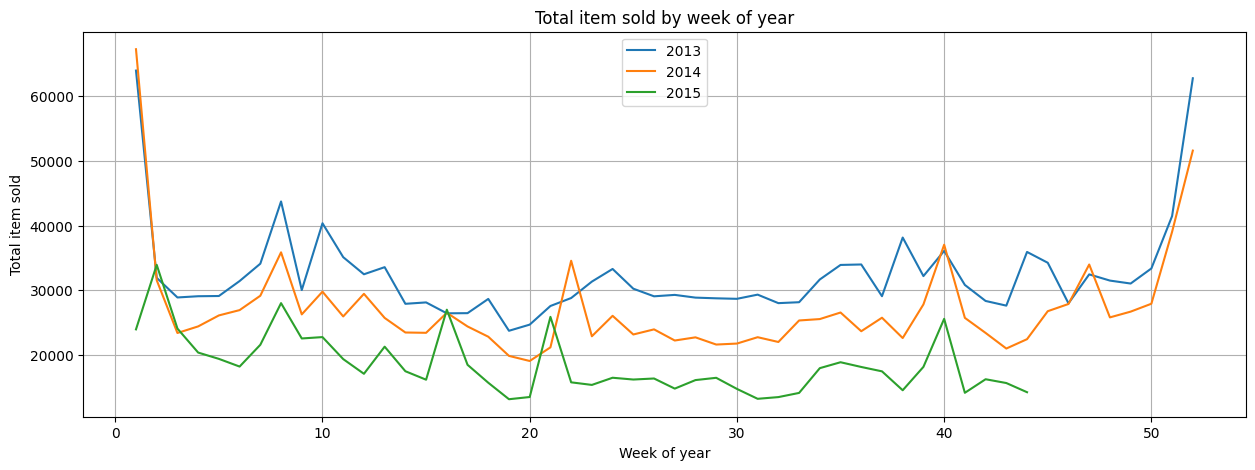

In [4]:
__train_df = _train_df.groupby(['date__year','date__week_of_year']).item_cnt_day.sum().reset_index()

plt.figure(figsize = (15,5))

for year in __train_df.date__year.unique():
    data = __train_df[__train_df['date__year'] == year]
    plt.plot(data.date__week_of_year, data.item_cnt_day, label=year)

plt.xlabel('Week of year')
plt.ylabel('Total item sold')
plt.title('Total item sold by week of year')

plt.legend(loc = 'upper center')
plt.grid()
plt.show()

**There is a clear seasonality in the sale of goods; there is no growth in sales in 2015 due to the lack of data for November and December.**

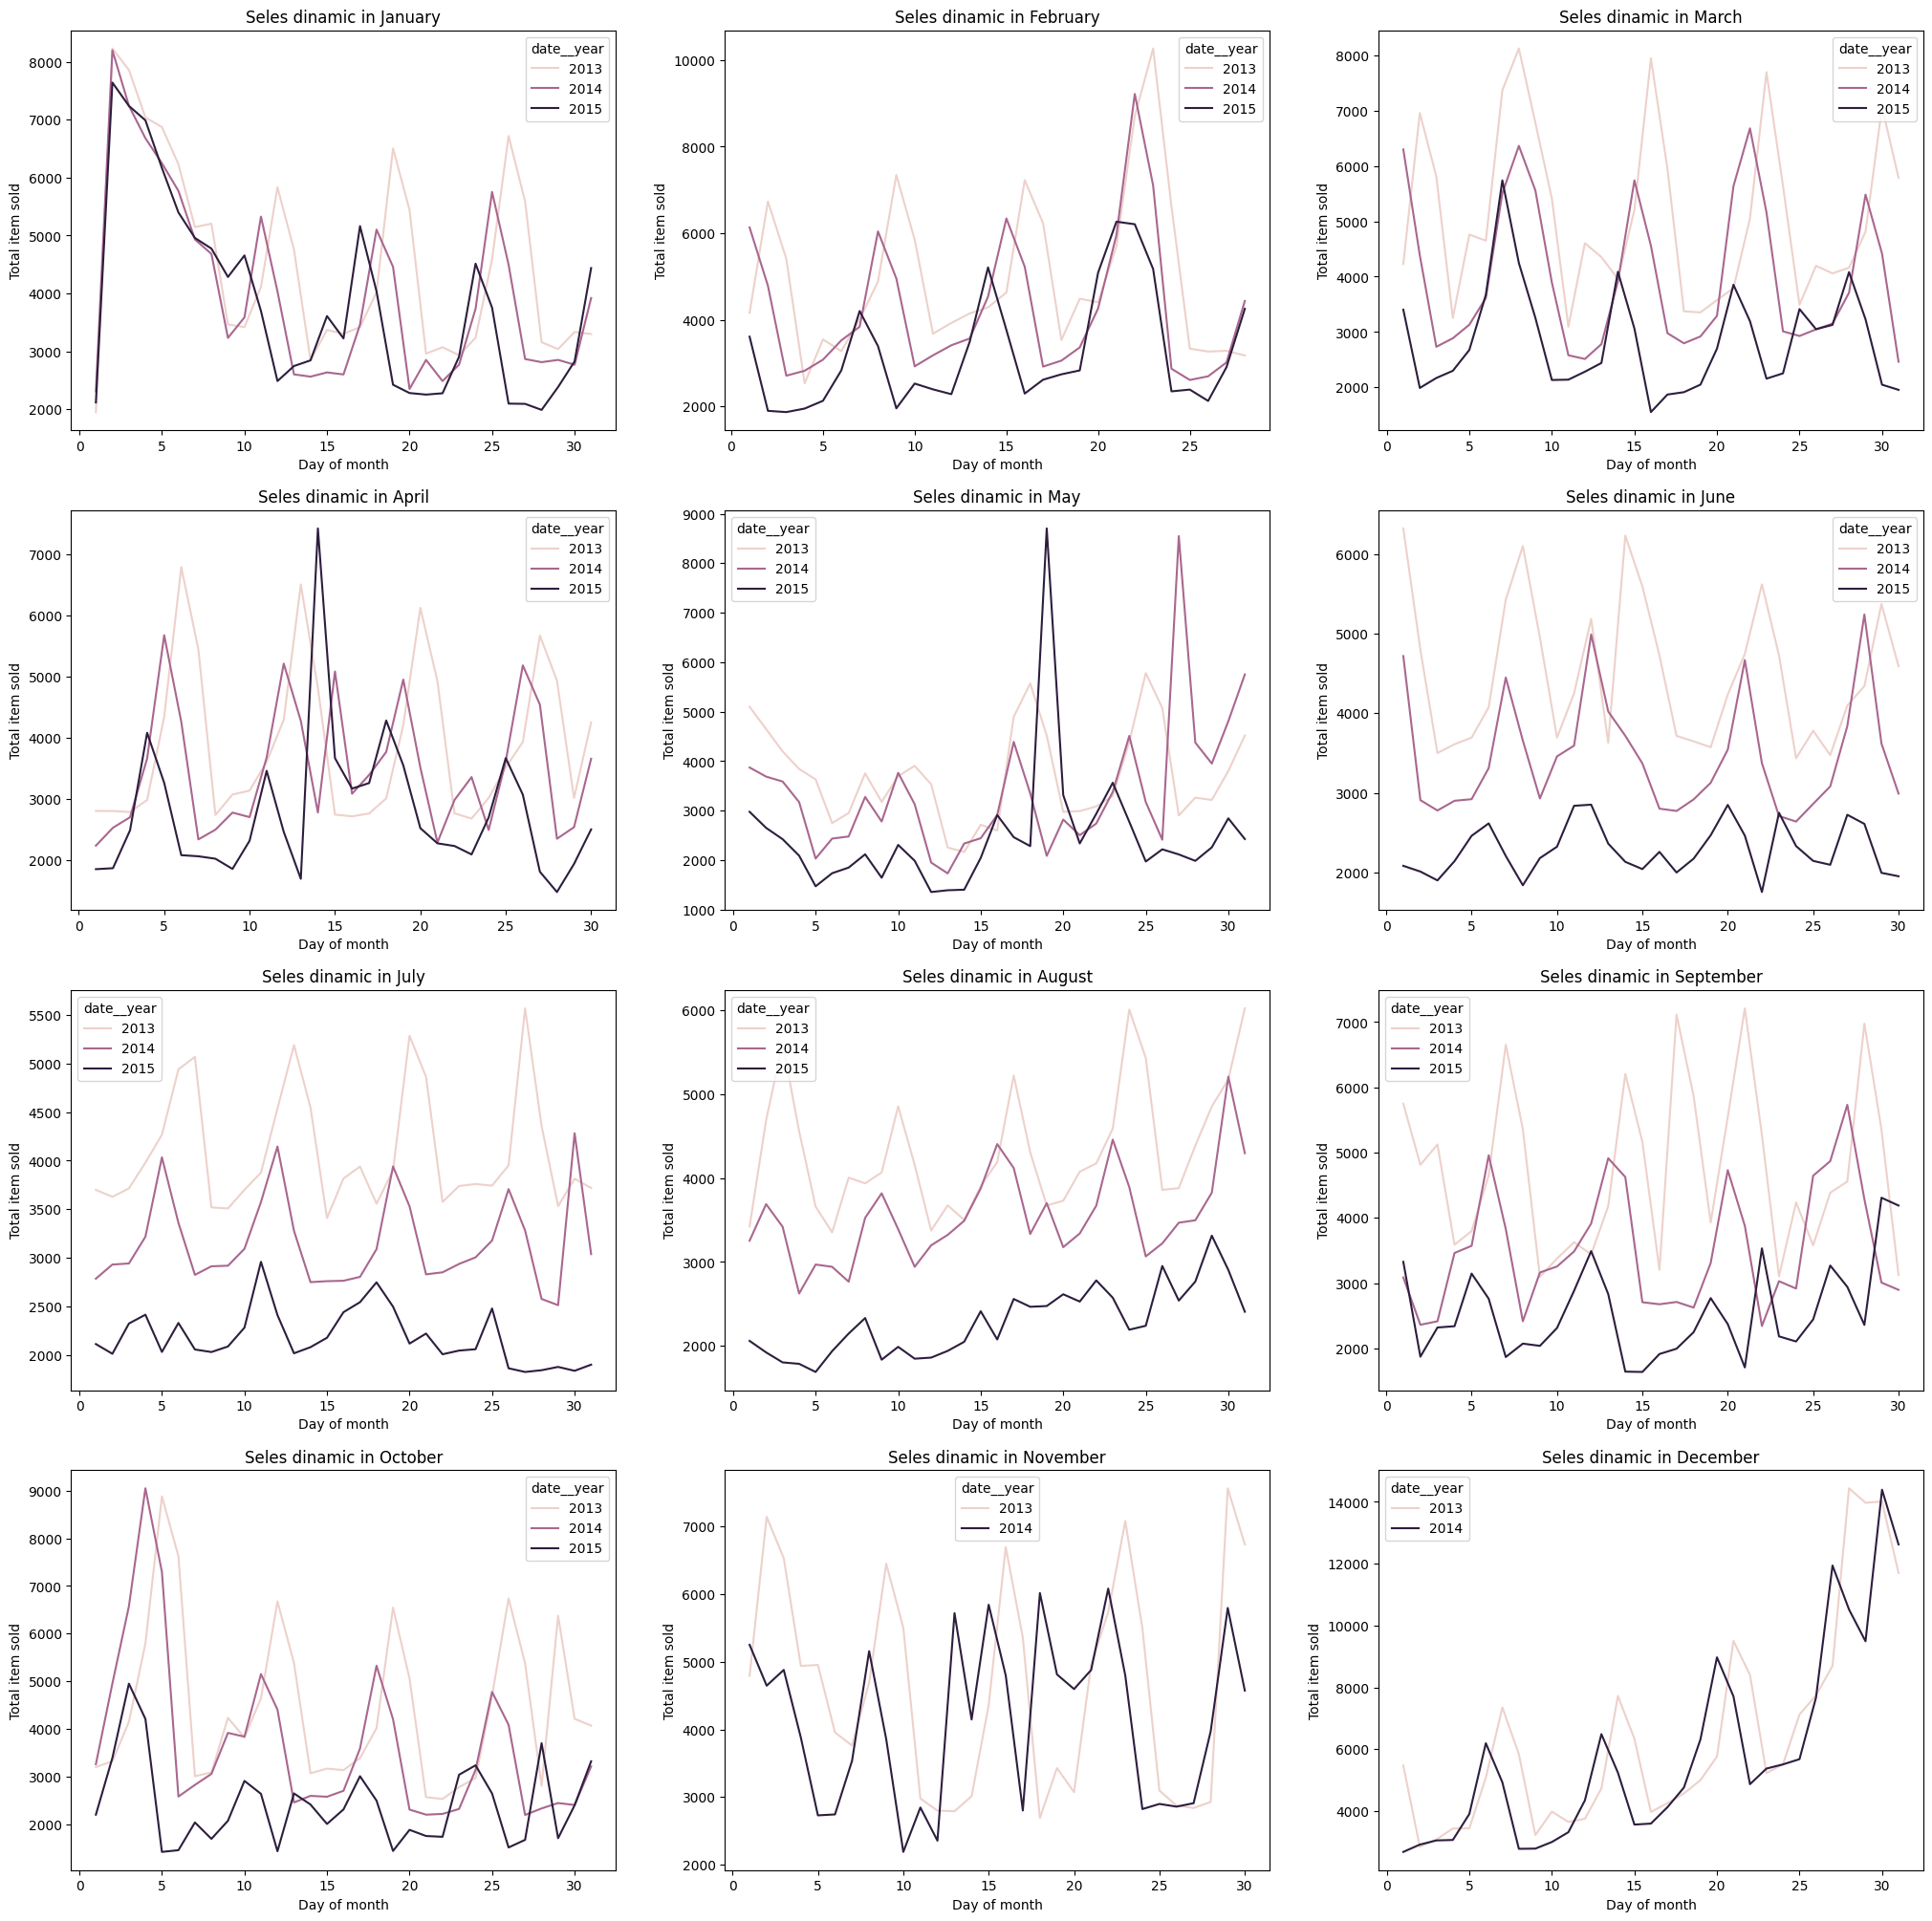

In [5]:
import calendar

__train_df = train_df_with_date.copy()
__train_df = __train_df.groupby(['date__year','date__month_of_year','date__day_of_month'])['item_cnt_day'].sum().reset_index()
__train_df

fif, axes = plt.subplots(4, 3, figsize=(25,25))

for i, month in enumerate(range(1,13)):
    sns.lineplot(data=__train_df[__train_df.date__month_of_year == month],
                 x='date__day_of_month', y='item_cnt_day', hue='date__year',
                 ax=axes[i//3][i%3]).set_title(f"Seles dinamic in {calendar.month_name[month]}")
    axes[i//3][i%3].set_xlabel('Day of month')
    axes[i//3][i%3].set_ylabel('Total item sold')

    

**In many months, there is a dependence on the day of the week; sales increase significantly on weekends.**

#### autocorrelation calculation to identify important months

In [6]:
train_df_with_date.date__month_of_start_sales.nunique()

34

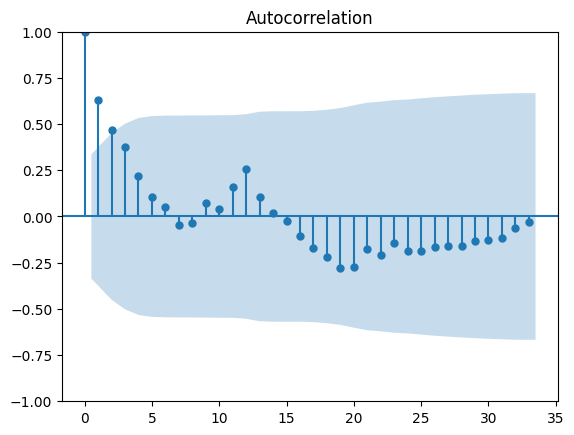

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf, acf, pacf

imm_monthly_dynamic = (train_df_with_date
     .groupby('date__month_of_start_sales')
     .agg({'item_cnt_day': 'sum'})
     .reset_index()
     .sort_values('date__month_of_start_sales', ascending=True))

res = plot_acf(x=imm_monthly_dynamic.item_cnt_day, lags=33)

**autocorrelation for each shops**

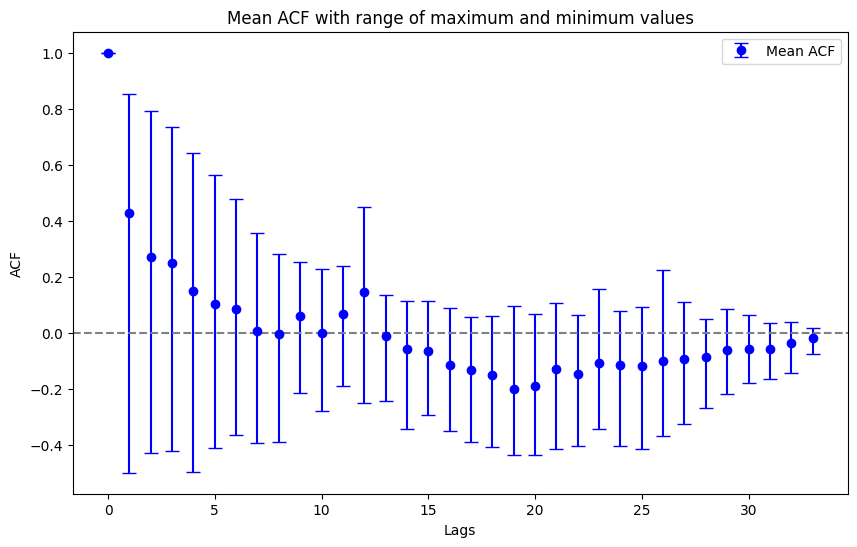

In [8]:

shops = train_df_with_date['shop_id'].unique()
max_lag = 33 

acf_values = []


for shop in shops:
    
    shop_data = train_df_with_date[train_df_with_date['shop_id'] == shop]

    shop_monthly_dynamic = (shop_data
                            .groupby('date__month_of_start_sales')
                            .agg({'item_cnt_day': 'sum'})
                            .reset_index()
                            .sort_values('date__month_of_start_sales', ascending=True))

    # Check if there is enough data to calculate ACF (at least 2 observations)
    if len(shop_monthly_dynamic['item_cnt_day']) > 1:
        # Calculate ACF for the current shop
        acf_vals = acf(shop_monthly_dynamic['item_cnt_day'], nlags=max_lag)
        
        if len(acf_vals) < max_lag + 1:
            acf_vals = np.pad(acf_vals, (0, max_lag + 1 - len(acf_vals)), 'constant', constant_values=0)
        
        acf_values.append(acf_vals)


acf_values = np.array(acf_values)

#Calculate the mean, maximum, and minimum ACF values
mean_acf = np.mean(acf_values, axis=0)  # Mean ACF value for all shops
max_acf = np.max(acf_values, axis=0)    # Maximum ACF values across all lags
min_acf = np.min(acf_values, axis=0)    # Minimum ACF values across all lags


lags = np.arange(0, max_lag + 1)

plt.figure(figsize=(10, 6))
plt.errorbar(lags, mean_acf, yerr=[mean_acf - min_acf, max_acf - mean_acf], fmt='o', capsize=5, label="Mean ACF", color='blue')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Mean ACF with range of maximum and minimum values")
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.legend()
plt.show()


**The graphs show that the previous month has the greatest significance and the remaining autocorrelation values ​​gradually decrease**

## 2.2 Sales by shop

In [9]:
_train_df = train_df.copy() 
_train_df = _train_df.groupby(['date_block_num', 'shop_id', 'shop_name'])['item_cnt_day'].sum()
_train_df = _train_df.reset_index()
#_train_df = _train_df.pivot(index='date_block_num', columns='shop_id', values='item_cnt_day') 
_train_df

date_block_num  shop_id                 shop_name  item_cnt_day
0                  0        0      якутскорджоникидзе56        5578.0
1                  0        0  якутскорджоникидзе56фран        5578.0
2                  0        1       якутсктццентральный        2947.0
3                  0        1   якутсктццентральныйфран        2947.0
4                  0        2              адыгеятцмега        1146.0
...              ...      ...                       ...           ...
1649              33       52          уфаткцентральный         847.0
1650              33       53               уфатцсемья2        1061.0
1651              33       55     цифровойсклад1сонлайн        1972.0
1652              33       56          чеховтрцкарнавал        1263.0
1653              33       59        ярославльтцальтаир         790.0

[1654 rows x 4 columns]

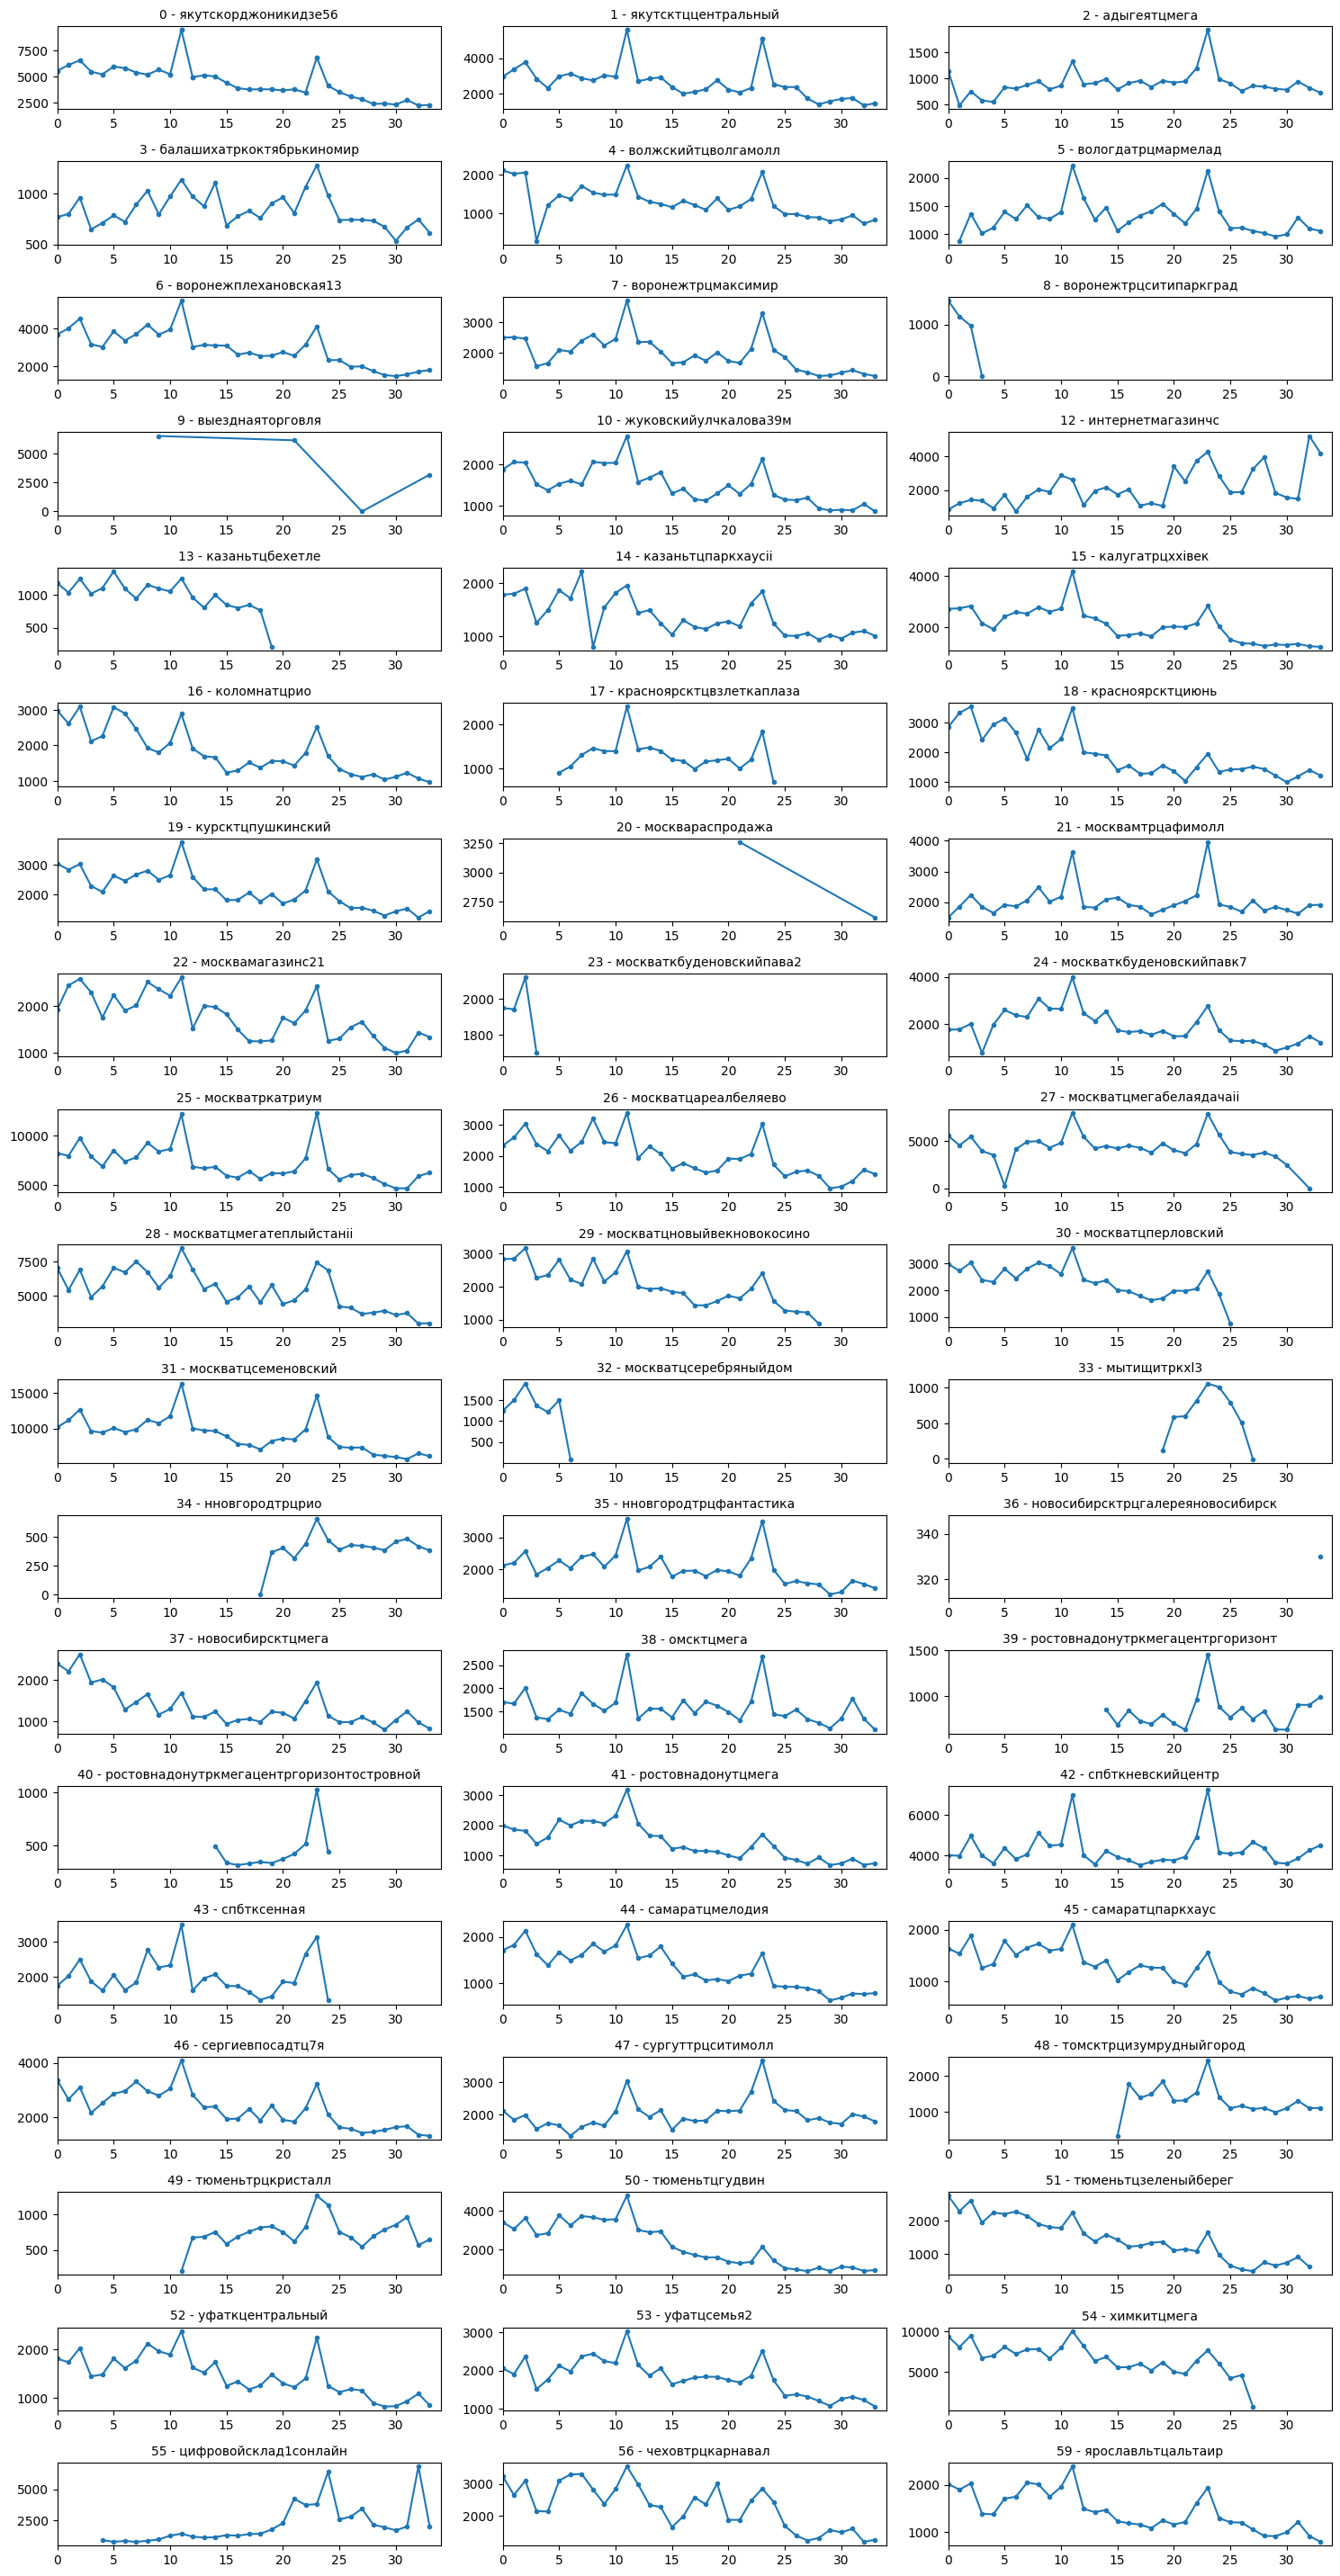

In [10]:
fig, axes = plt.subplots(20,3, figsize=(15,30))
shops = _train_df['shop_id'].unique()
shops.sort()
for i in range(len(shops)):
    shop = shops[i]
    shop_data = _train_df[_train_df['shop_id'] == shop]
    axes[i//3][i%3].plot(shop_data['date_block_num'], shop_data['item_cnt_day'], marker='.')
    axes[i//3][i%3].set_xlim(0,34)
    axes[i//3][i%3].set_title(f'{shop} - {shop_data.shop_name.iloc[0]}', fontsize=10)

#remove empty plots
num_shops_to_plot = len(shops)
if num_shops_to_plot < len(axes.flatten()):
    for j in range(num_shops_to_plot, len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

fig.tight_layout()

**The dependence of sales on stores is visible; some have closed or are open seasonally; it makes sense to remove stores that have very low activity.**

## 2.3 Sales by categoty

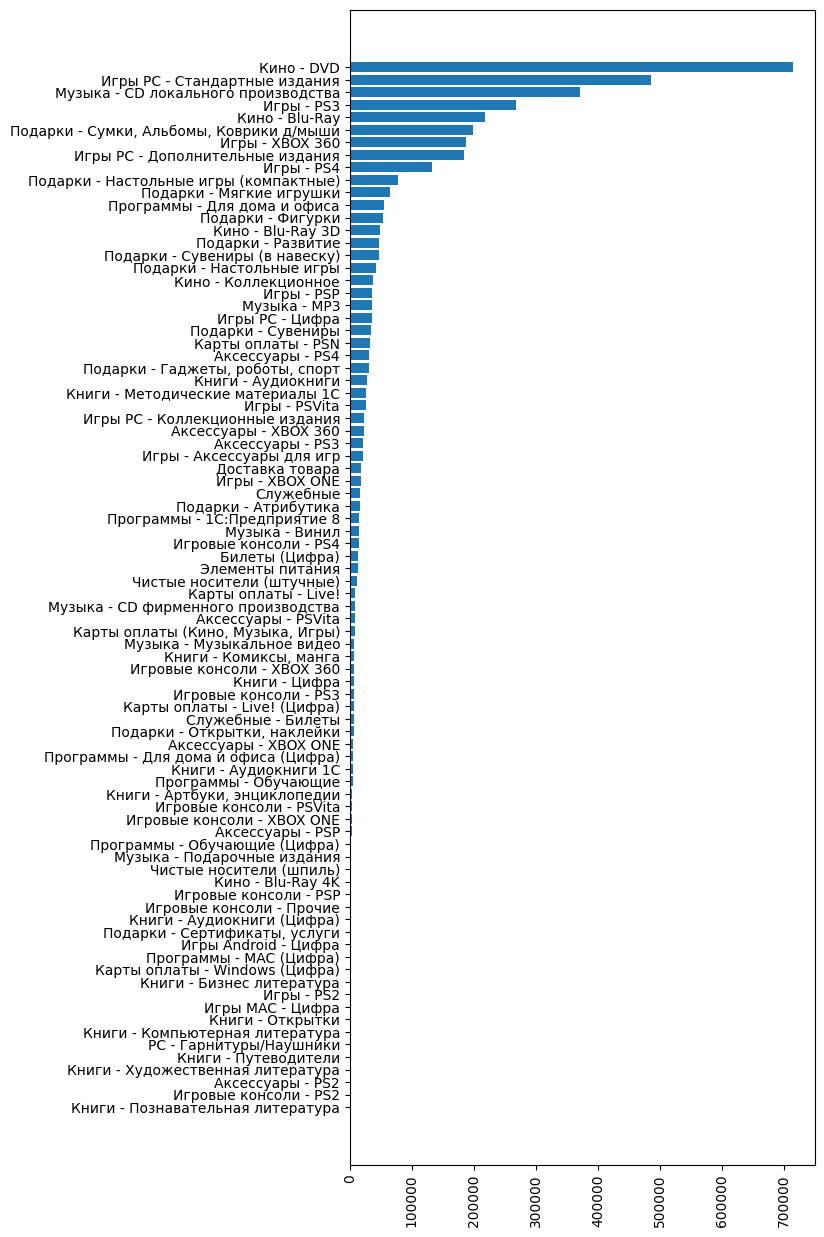

In [11]:
df= (train_df.groupby('item_category_name')['item_cnt_day'].sum()
     .reset_index()
     .sort_values('item_cnt_day'))
plt.figure(figsize=(6, 15))
plt.barh(df['item_category_name'], df['item_cnt_day'])
plt.xticks(rotation=90)
plt.show()

**Games, music and movies are the best sellers. The category can be used as a feature. But are all categories active?**

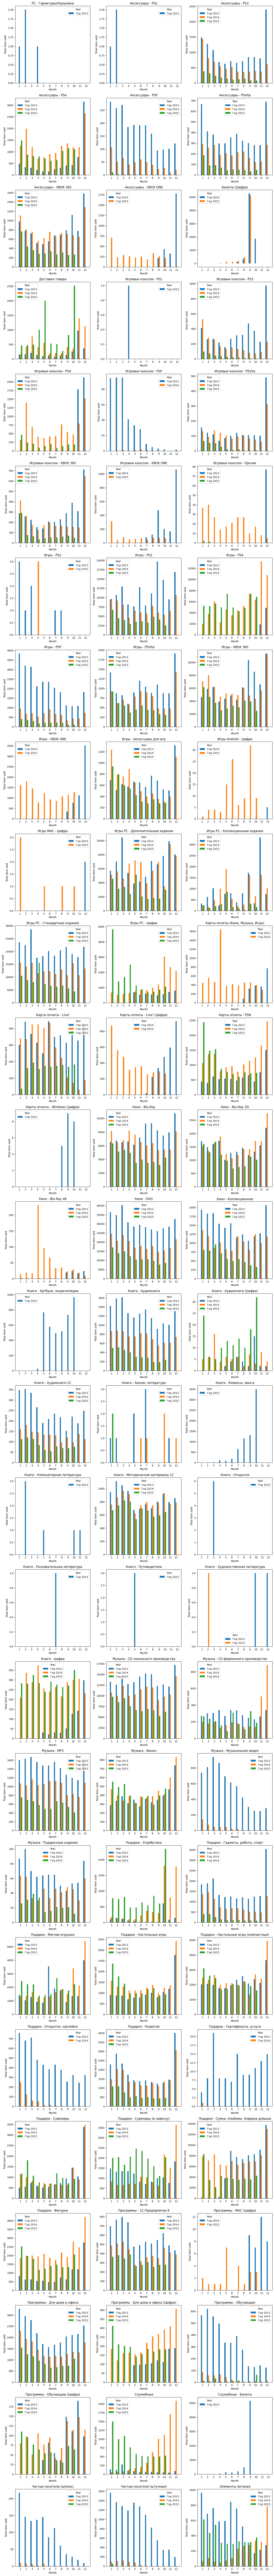

In [12]:
df = train_df_with_date.copy()
df = (df.groupby(['item_category_name', 'date__month_of_year', 'date__year'])['item_cnt_day'].sum()
     .reset_index())
categories = df['item_category_name'].unique()


months = df['date__month_of_year'].unique()
months.sort()


num_columns = 3
num_rows = (len(categories) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()  

for i, category in enumerate(categories):
    category_data = df[df['item_category_name'] == category]
    
    sales_by_month_and_year = (category_data.groupby(['date__month_of_year', 'date__year'])['item_cnt_day']
                               .sum()
                               .unstack(fill_value=0))

    width = 0.2
    x = np.arange(len(months))

    for j, year in enumerate(sales_by_month_and_year.columns):
        values = sales_by_month_and_year[year].reindex(months, fill_value=0)
        axes[i].bar(x + j * width, values, width, label=f'Год {year}')

    axes[i].set_title(category)
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Total item sald')
    axes[i].set_xticks(x + width * (len(sales_by_month_and_year.columns) - 1) / 2)
    axes[i].set_xticklabels(months)
    axes[i].legend(title='Year')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**It is clear that the product categories are not active at the moment, some categories appeared and some left, it will be possible to make a mark on the active category**

## Sales by global categories 

In [13]:
train_df_with_date['global_category'] = train_df_with_date['item_category_name'].apply(lambda x: x.split(' - ')[0])

train_df_with_date.head()

date  date__month_of_start_sales  shop_id  item_id  item_price  \
0 2013-01-01                           0        2      991        99.0   
1 2013-01-01                           0        2     1472      2599.0   
2 2013-01-01                           0        2     1905       249.0   
3 2013-01-01                           0        2     2920       599.0   
4 2013-01-01                           0        2     3320      1999.0   

      shop_name                                          item_name  \
0  адыгеятцмега                  3dactionpuzzleдинозаврытиранозавр   
1  адыгеятцмега                assassinscreed3xbox360русскаяверсия   
2  адыгеятцмега          bestsellergrandtheftautosanandreaspcjewel   
3  адыгеятцмега  disneylegoпиратыкарибскогоморяessentialspspрус...   
4  адыгеятцмега            fifa13споддержкойpsmoveps3русскаяверсия   

   item_category_id             item_category_name  item_cnt_day  \
0                67             Подарки - Развитие           1.0   
1                23                Игры - XBOX 360           1.0   
2                30  Игры PC - Стандартные издания           1.0   
3                21                     Игры - PSP           2.0   
4                19                     Игры - PS3           1.0   

   date__week_of_start_sales  date__day_of_month  date__day_of_week  \
0                          0                   1                  1   
1                          0                   1                  1   
2                          0                   1                  1   
3                          0                   1                  1   
4                          0                   1                  1   

   date__week_of_year  date__month_of_year  date__year global_category  
0                   1                    1        2013         Подарки  
1                   1                    1        2013            Игры  
2                   1                    1        2013         Игры PC  
3                   1                    1        2013            Игры  
4                   1                    1        2013            Игры

In [14]:
train_df_with_date.global_category.unique()

array(['Подарки', 'Игры', 'Игры PC', 'Аксессуары', 'Кино',
       'Игровые консоли', 'Программы', 'Музыка', 'Служебные', 'Книги',
       'Чистые носители (штучные)', 'Элементы питания', 'Карты оплаты',
       'Чистые носители (шпиль)', 'Карты оплаты (Кино, Музыка, Игры)',
       'Доставка товара', 'Билеты (Цифра)', 'Игры Android', 'PC',
       'Игры MAC'], dtype=object)

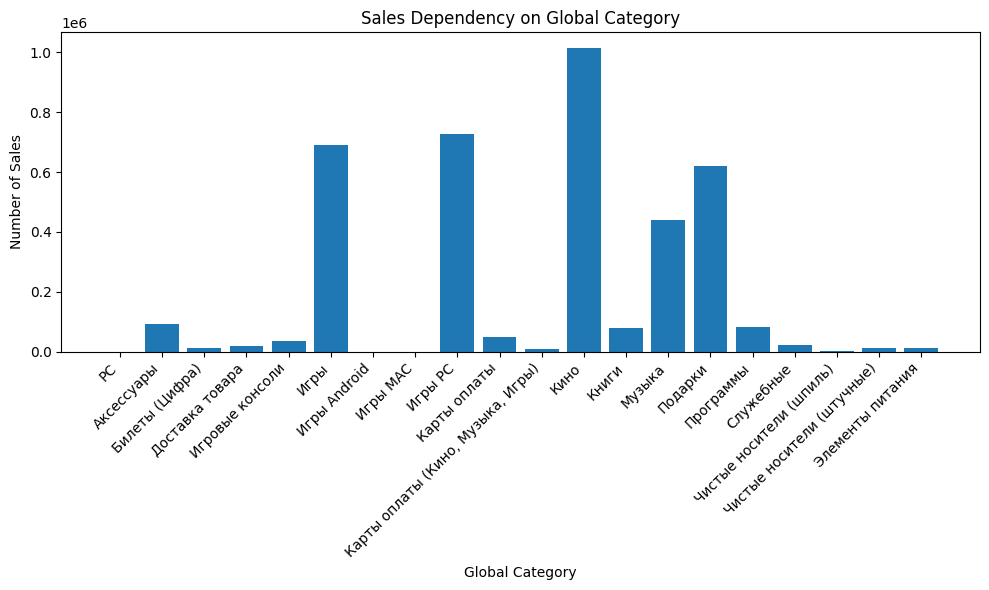

In [15]:
# Group data by global category and sum sales
category_sales = train_df_with_date.groupby('global_category')['item_cnt_day'].sum().reset_index()

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(category_sales['global_category'], category_sales['item_cnt_day'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Global Category')
plt.ylabel('Number of Sales')
plt.title('Sales Dependency on Global Category')
plt.tight_layout()
plt.show()

***Analysis of Sales by Global Category***

1. **Games**: This category has the highest number of sales, indicating a strong popularity and demand for video games.

2. **Books and Movies**: These categories also show significant sales, reflecting a steady interest in these products.

3. **Music and Software**: These categories have moderate sales, suggesting they are less popular compared to games and books.

4. **Other Categories**: Most other categories, such as accessories and blank media, have relatively low sales, indicating lesser demand.
росе.

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                      global_category  item_cnt_day  cluster
0                                  PC           4.0        0
1                          Аксессуары       91504.0        0
2                      Билеты (Цифра)       13714.0        0
3                     Доставка товара       18118.0        0
4                     Игровые консоли       34855.0        0
5                                Игры      689731.0        2
6                        Игры Android         114.0        0
7                            Игры MAC           8.0        0
8                             Игры PC      727203.0        2
9                        Карты оплаты       48559.0        0
10  Карты оплаты (Кино, Музыка, Игры)        7801.0        0
11                               Кино     1016322.0        1
12                              Книги       77840.0        0
13                             Музыка      438524.0        2
14                            Подарки      618844.0        2
15                      

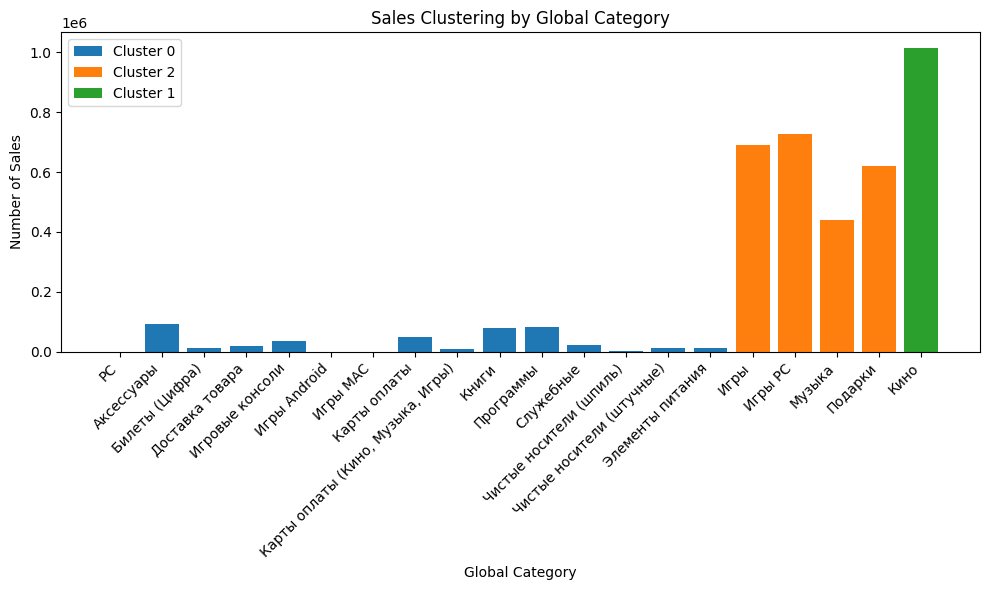

In [16]:
from sklearn.cluster import KMeans

X = category_sales[['item_cnt_day']]


kmeans = KMeans(n_clusters=3, random_state=0)

# Fit the model
category_sales['cluster'] = kmeans.fit_predict(X)

# Print clustered categories
print(category_sales)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster in category_sales['cluster'].unique():
    subset = category_sales[category_sales['cluster'] == cluster]
    plt.bar(subset['global_category'], subset['item_cnt_day'], label=f'Cluster {cluster}')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Global Category')
plt.ylabel('Number of Sales')
plt.title('Sales Clustering by Global Category')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
category_sales_map = category_sales.set_index('global_category')['cluster'].to_dict()
train_df_with_date['global_category'] = train_df_with_date.global_category.map(category_sales_map)
train_df_with_date

date  date__month_of_start_sales  shop_id  item_id  item_price  \
0       2013-01-01                           0        2      991        99.0   
1       2013-01-01                           0        2     1472      2599.0   
2       2013-01-01                           0        2     1905       249.0   
3       2013-01-01                           0        2     2920       599.0   
4       2013-01-01                           0        2     3320      1999.0   
...            ...                         ...      ...      ...         ...   
3140212 2014-12-31                          23       59    20404      2399.0   
3140213 2014-12-31                          23       59    20610      1099.0   
3140214 2014-12-31                          23       59    20949         5.0   
3140215 2014-12-31                          23       59    21762      1499.0   
3140216 2014-12-31                          23       59    22087        99.0   

                  shop_name  \
0              адыгеятцмега   
1              адыгеятцмега   
2              адыгеятцмега   
3              адыгеятцмега   
4              адыгеятцмега   
...                     ...   
3140212  ярославльтцальтаир   
3140213  ярославльтцальтаир   
3140214  ярославльтцальтаир   
3140215  ярославльтцальтаир   
3140216  ярославльтцальтаир   

                                                 item_name  item_category_id  \
0                        3dactionpuzzleдинозаврытиранозавр                67   
1                      assassinscreed3xbox360русскаяверсия                23   
2                bestsellergrandtheftautosanandreaspcjewel                30   
3        disneylegoпиратыкарибскогоморяessentialspspрус...                21   
4                  fifa13споддержкойpsmoveps3русскаяверсия                19   
...                                                    ...               ...   
3140212  фигуркаassassinscreedunityarnothefearlessassas...                72   
3140213  фигуркаminecraftseries1zombiewithironswordandi...                72   
3140214         фирменныйпакетмайка1синтересбелый344245мкм                71   
3140215                                  чужойантология6bd                41   
3140216                      элементпитанияduracelllr03bc2                83   

                               item_category_name  item_cnt_day  \
0                              Подарки - Развитие           1.0   
1                                 Игры - XBOX 360           1.0   
2                   Игры PC - Стандартные издания           1.0   
3                                      Игры - PSP           2.0   
4                                      Игры - PS3           1.0   
...                                           ...           ...   
3140212                         Подарки - Фигурки           1.0   
3140213                         Подарки - Фигурки           1.0   
3140214  Подарки - Сумки, Альбомы, Коврики д/мыши           5.0   
3140215                      Кино - Коллекционное           1.0   
3140216                          Элементы питания           1.0   

         date__week_of_start_sales  date__day_of_month  date__day_of_week  \
0                                0                   1                  1   
1                                0                   1                  1   
2                                0                   1                  1   
3                                0                   1                  1   
4                                0                   1                  1   
...                            ...                 ...                ...   
3140212                        104                  31                  2   
3140213                        104                  31                  2   
3140214                        104                  31                  2   
3140215                        104                  31                  2   
3140216                        104                  31             

## 2.4 Dependence of sales on the age of goods and the store

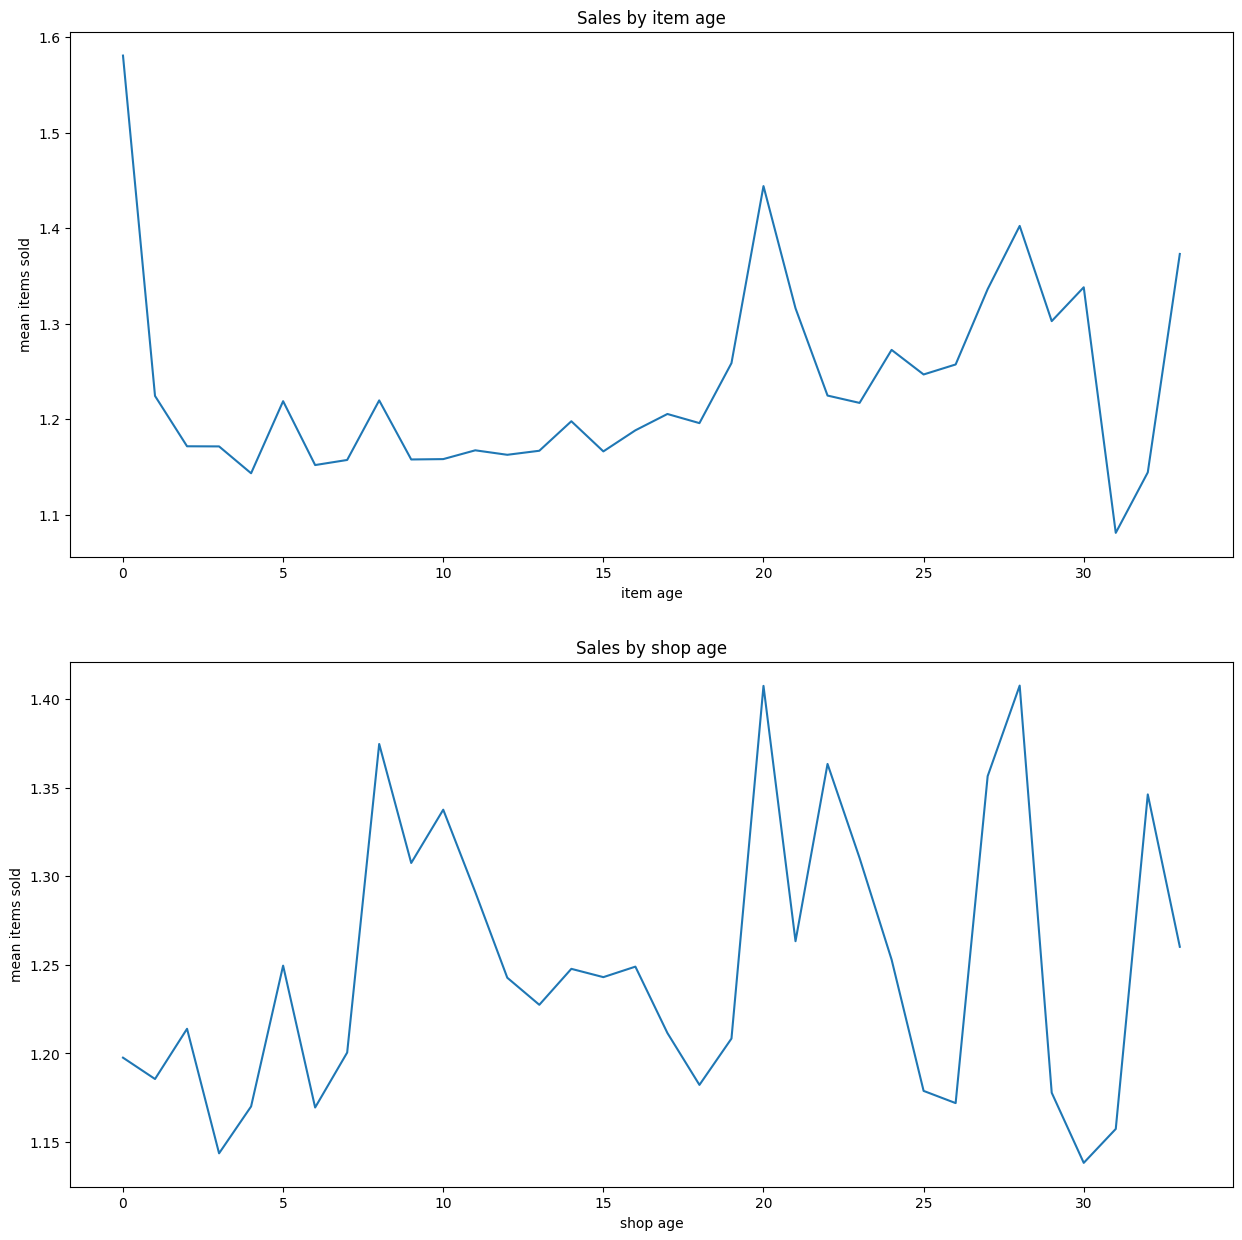

In [18]:
def item_and_shop_age(df):
    df = df.copy()
    df['item_age'] = df.groupby(['item_id', ])['date_block_num'].transform( 
        lambda x: x - x.min() ) 
    df['shop_age'] = df.groupby(['shop_id', ])['date_block_num'].transform( 
        lambda x: x - x.min() ) 
    return df
    
df = item_and_shop_age(train_df)

fig, axes = plt.subplots(2, 1, figsize=(15,15))

ax = df.groupby('item_age').item_cnt_day.mean().plot(
    ylabel = 'mean items sold', xlabel = 'item age',
    title = 'Sales by item age', ax = axes[0])

ax = df.groupby('shop_age').item_cnt_day.mean().plot(
    ylabel = 'mean items sold', xlabel = 'shop age',
    title = 'Sales by shop age', ax = axes[1])



**There is a relationship between the age of the product (number of months since it first appeared in the data) and the number of sales, and no clear relationship with the age of the store, as can be seen in the second graph. (You can take the age of the product as a useful feature)**

## 2.5 Sales by price 

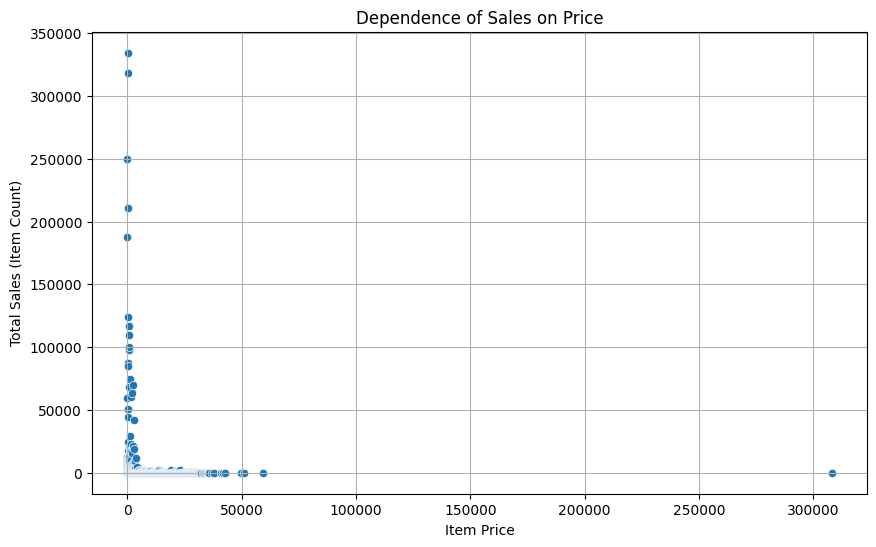

In [19]:
# Grouped data by price and total sales volume
sales_by_price = train_df_with_date.groupby('item_price')['item_cnt_day'].sum().reset_index()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_by_price, x='item_price', y='item_cnt_day')


plt.title('Dependence of Sales on Price')
plt.xlabel('Item Price')
plt.ylabel('Total Sales (Item Count)')
plt.grid(True)
plt.show()

**It can be seen that the number of sales of goods depends on the price (the higher the price, the fewer sales). But we cannot use this feature since the price data is presented only in the set for training the model**

## 2.6 Sales by city

In [20]:
# function to extract the city
def extract_city(shop_name):
    # Try to extract the city before the first occurrence of the words 'тц', 'трц', etc.
    match = re.search(r'([а-яё]+)(тц|трц|мтрц| )', shop_name.lower())
    if match:
        return match.group(1)  # Return the first group (city)
    
    # If the pattern didn't match, add more specific rules
    if 'спб' in shop_name.lower():
        return 'санкт-петербург'
    elif 'москва' in shop_name.lower():
        return 'москва'
    elif 'ростовнадону' in shop_name.lower() or 'ростовнадону' == shop_name.lower():
        return 'ростов на дону'
    elif 'воронеж' in shop_name.lower():
        return 'воронеж' 
    elif 'жуковский' in shop_name.lower():
        return 'жуковский'    
    elif 'выезднаяторговля' in shop_name.lower():
        return 'выездная торговля'  
    elif 'балашиха' in shop_name.lower():
        return 'балашиха'
    elif 'якутск' in shop_name.lower():
        return 'якутск'
    elif 'уфа' in shop_name.lower():
        return 'уфа'
    elif 'мытищи' in shop_name.lower():
        return 'мытищи'
    elif 'цифровойсклад' in shop_name.lower() or 'интернетмагазин' in shop_name.lower():
        return 'онлайн-магазин'
    
    # If nothing matched, return the original name as the "city"
    return shop_name

# Apply the function to the entire shop_name column and create a new city column
train_df_with_date['city'] = train_df_with_date['shop_name'].apply(extract_city)

# Check the result
print(train_df_with_date[['shop_name', 'city']].drop_duplicates().head(50))


                        shop_name             city
0                    адыгеятцмега           адыгея
23             воронежтрцмаксимир          воронеж
110        воронежтрцситипаркград          воронеж
158               казаньтцбехетле           казань
186            казаньтцпаркхаусii           казань
246               калугатрцxxiвек           калуга
353              красноярсктциюнь       красноярск
421             курсктцпушкинский            курск
524       москватцмегабелаядачаii           москва
703      москватцмегатеплыйстанii           москва
900             новосибирсктцмега      новосибирск
972                    омсктцмега             омск
1008           ростовнадонутцмега     ростовнадону
1053            спбткневскийцентр  санкт-петербург
1141             сергиевпосадтц7я     сергиевпосад
1227         тюменьтцзеленыйберег           тюмень
1340                  химкитцмега            химки
1700           вологдатрцмармелад          вологда
2586           москватцперловск

In [21]:
print(train_df_with_date.shop_name.nunique(), "- number of unique store names")
print(train_df_with_date.city.nunique(), "- number of unique city names")

59 - number of unique store names
32 - number of unique city names


C:\Users\Asus\AppData\Local\Temp\ipykernel_26032\4233599629.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_cnt_day', y='city', data=city_sales, palette='viridis')


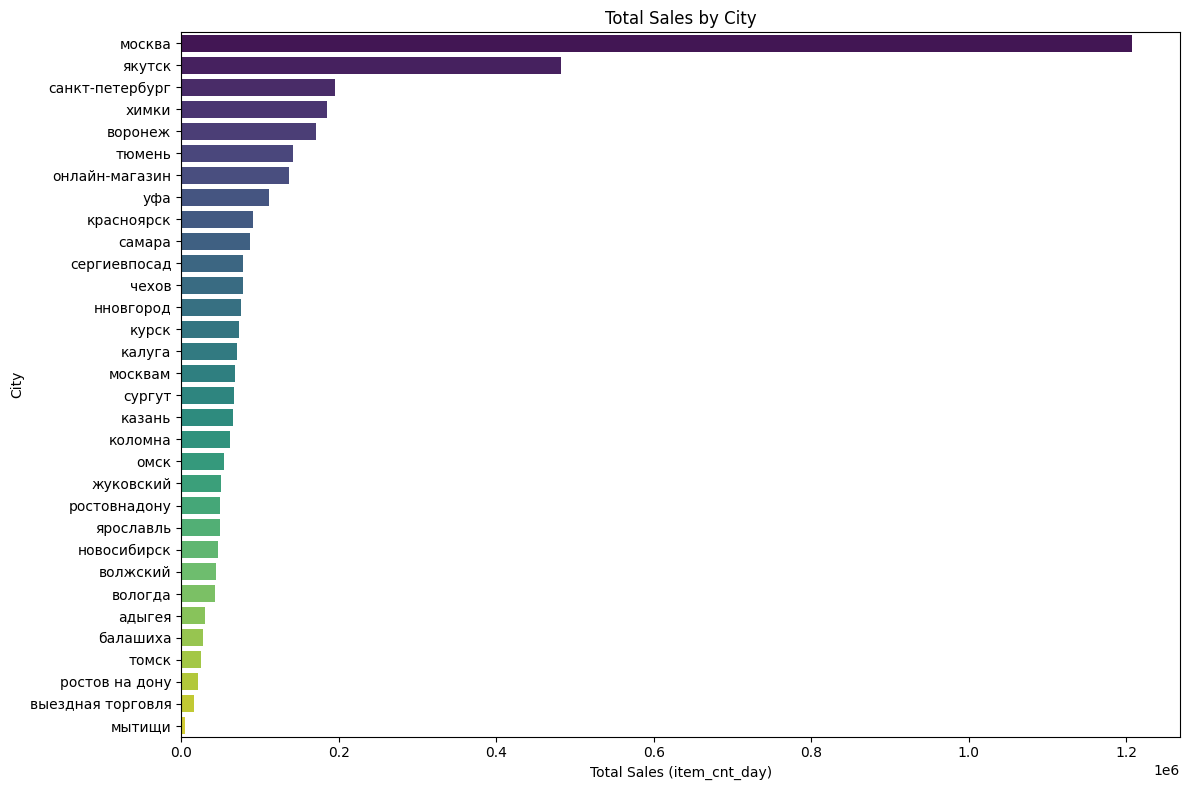

In [22]:
# Aggregate sales by city
city_sales = train_df_with_date.groupby('city')['item_cnt_day'].sum().reset_index()

#  Sort the data by total sales (optional but makes the plot more interpretable)
city_sales = city_sales.sort_values(by='item_cnt_day', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='item_cnt_day', y='city', data=city_sales, palette='viridis')

# Adding labels and title
plt.xlabel('Total Sales (item_cnt_day)')
plt.ylabel('City')
plt.title('Total Sales by City')

# Display the plot
plt.tight_layout()
plt.show()

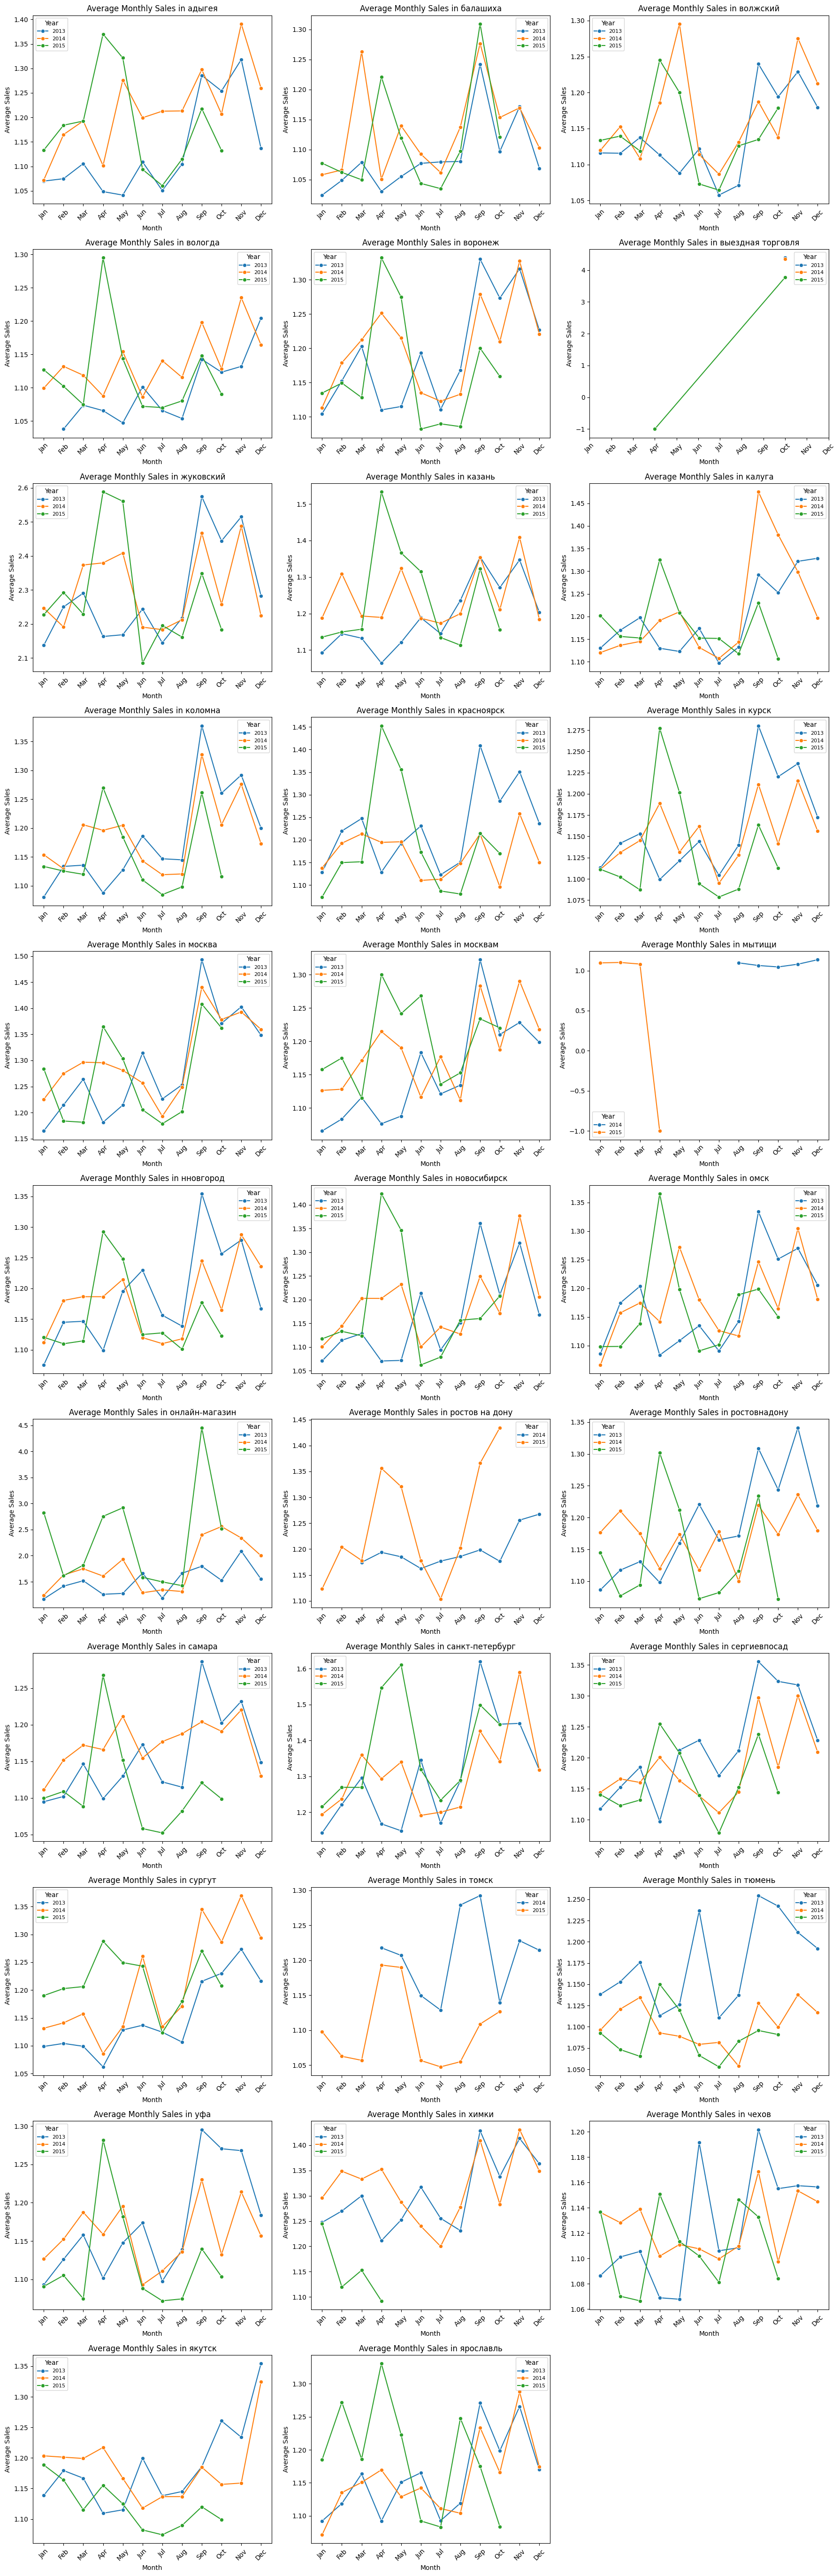

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column that combines month and year
train_df_with_date['month'] = train_df_with_date['date__month_of_year']
train_df_with_date['year'] = train_df_with_date['date__year']

# Group by city, year, and month to calculate the average sales per store
monthly_avg_sales = train_df_with_date.groupby(['city', 'year', 'month'])['item_cnt_day'].mean().reset_index()

# Get the list of unique cities for individual plots
cities = monthly_avg_sales['city'].unique()

# Set up subplots: 3 plots per row
num_cities = len(cities)
num_cols = 3
num_rows = (num_cities + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a plot for each city
for idx, city in enumerate(cities):
    city_data = monthly_avg_sales[monthly_avg_sales['city'] == city]
    
    # Plot data for each year
    for year in city_data['year'].unique():
        yearly_data = city_data[city_data['year'] == year]
        sns.lineplot(x='month', y='item_cnt_day', data=yearly_data, marker='o', label=str(year), ax=axes[idx])
    
    # Set title and labels for the plot
    axes[idx].set_title(f'Average Monthly Sales in {city}', fontsize=12)
    axes[idx].set_xlabel('Month', fontsize=10)
    axes[idx].set_ylabel('Average Sales', fontsize=10)
    
    # Set x-ticks for months
    axes[idx].set_xticks(range(1, 13))
    axes[idx].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add legend for years
    axes[idx].legend(title='Year', fontsize=8)

# Hide unused subplots if there are any
for i in range(idx + 1, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout to make it tidy
plt.tight_layout()
plt.show()


**It is evident that the number of sales varies depending on the city - larger cities tend to have more stores. However, in the second graph, we can see the average sales per store, meaning we don't account for the number of stores in each city. This provides insight into the specific seasonality and overall sales level observed in each individual city.**

### Target encoding for cities based on the average monthly sales

In [24]:
sales_cnt_month = (train_df_with_date.groupby(['city', 'date__month_of_start_sales'])['item_cnt_day'].sum().reset_index())
mean_sales = sales_cnt_month.groupby(['city'])['item_cnt_day'].mean().reset_index().rename(columns={'item_cnt_day' : 'mean_item_cnt'})
mean_sales['mean_item_cnt'] = mean_sales['mean_item_cnt'].astype(int)

mean_sales_map = mean_sales.set_index('city')['mean_item_cnt'].to_dict()

train_df_with_date['city'] = train_df_with_date.city.map(mean_sales_map)
train_df_with_date

date  date__month_of_start_sales  shop_id  item_id  item_price  \
0       2013-01-01                           0        2      991        99.0   
1       2013-01-01                           0        2     1472      2599.0   
2       2013-01-01                           0        2     1905       249.0   
3       2013-01-01                           0        2     2920       599.0   
4       2013-01-01                           0        2     3320      1999.0   
...            ...                         ...      ...      ...         ...   
3140212 2014-12-31                          23       59    20404      2399.0   
3140213 2014-12-31                          23       59    20610      1099.0   
3140214 2014-12-31                          23       59    20949         5.0   
3140215 2014-12-31                          23       59    21762      1499.0   
3140216 2014-12-31                          23       59    22087        99.0   

                  shop_name  \
0              адыгеятцмега   
1              адыгеятцмега   
2              адыгеятцмега   
3              адыгеятцмега   
4              адыгеятцмега   
...                     ...   
3140212  ярославльтцальтаир   
3140213  ярославльтцальтаир   
3140214  ярославльтцальтаир   
3140215  ярославльтцальтаир   
3140216  ярославльтцальтаир   

                                                 item_name  item_category_id  \
0                        3dactionpuzzleдинозаврытиранозавр                67   
1                      assassinscreed3xbox360русскаяверсия                23   
2                bestsellergrandtheftautosanandreaspcjewel                30   
3        disneylegoпиратыкарибскогоморяessentialspspрус...                21   
4                  fifa13споддержкойpsmoveps3русскаяверсия                19   
...                                                    ...               ...   
3140212  фигуркаassassinscreedunityarnothefearlessassas...                72   
3140213  фигуркаminecraftseries1zombiewithironswordandi...                72   
3140214         фирменныйпакетмайка1синтересбелый344245мкм                71   
3140215                                  чужойантология6bd                41   
3140216                      элементпитанияduracelllr03bc2                83   

                               item_category_name  item_cnt_day  \
0                              Подарки - Развитие           1.0   
1                                 Игры - XBOX 360           1.0   
2                   Игры PC - Стандартные издания           1.0   
3                                      Игры - PSP           2.0   
4                                      Игры - PS3           1.0   
...                                           ...           ...   
3140212                         Подарки - Фигурки           1.0   
3140213                         Подарки - Фигурки           1.0   
3140214  Подарки - Сумки, Альбомы, Коврики д/мыши           5.0   
3140215                      Кино - Коллекционное           1.0   
3140216                          Элементы питания           1.0   

         date__week_of_start_sales  date__day_of_month  date__day_of_week  \
0                                0                   1                  1   
1                                0                   1                  1   
2                                0                   1                  1   
3                                0                   1                  1   
4                                0                   1                  1   
...                            ...                 ...                ...   
3140212                        104                  31                  2   
3140213                        104                  31                  2   
3140214                        104                  31                  2   
3140215                        104                  31                  2   
3140216                        104                  31             